In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from data import TSDataset, enrich_raw_ts
from models.CNNAE import CNNAE
from utils import train_model, detect_outlier, save_result

如果计算机安装有CUDA，则使用CUDA进行接下来的全部训练，否则使用CPU

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


# 数据预处理

读取训练数据和测试数据

In [3]:
# 训练数据
train_data_path = "dataset/train.csv"
df_train = pd.read_csv(train_data_path, index_col=0)
print(df_train.shape)
print(df_train.head())
print(df_train.isnull().sum())  # 检查是否有缺失值
df_train.ffill(inplace=True)  # 用前一个有效的观测值来填充缺失值

# 测试数据
test_data_path = "dataset/test.csv"
df_test = pd.read_csv(test_data_path, index_col=0)
print(df_test.shape)
print(df_test.head())
print(df_test.isnull().sum())  # 检查是否有缺失值

(132481, 25)
                 feature_0  feature_1  feature_2  feature_3  feature_4  \
timestamp_(min)                                                          
0.0               0.732689   0.761748   0.606848   0.488746   0.424310   
1.0               0.732799   0.761855   0.607133   0.488781   0.432008   
2.0               0.732938   0.761594   0.606895   0.488791   0.418858   
3.0               0.732893   0.761656   0.606478   0.488802   0.417896   
4.0               0.732788   0.761573   0.606777   0.488800   0.421103   

                 feature_5  feature_6  feature_7  feature_8  feature_9  ...  \
timestamp_(min)                                                         ...   
0.0               0.403609   0.519318   0.398792   0.451453   0.447077  ...   
1.0               0.410256   0.511364   0.402568   0.455657   0.449474  ...   
2.0               0.407724   0.488636   0.396526   0.456104   0.451282  ...   
3.0               0.404242   0.500000   0.405589   0.460020   0.456628  .

原始数据可视化

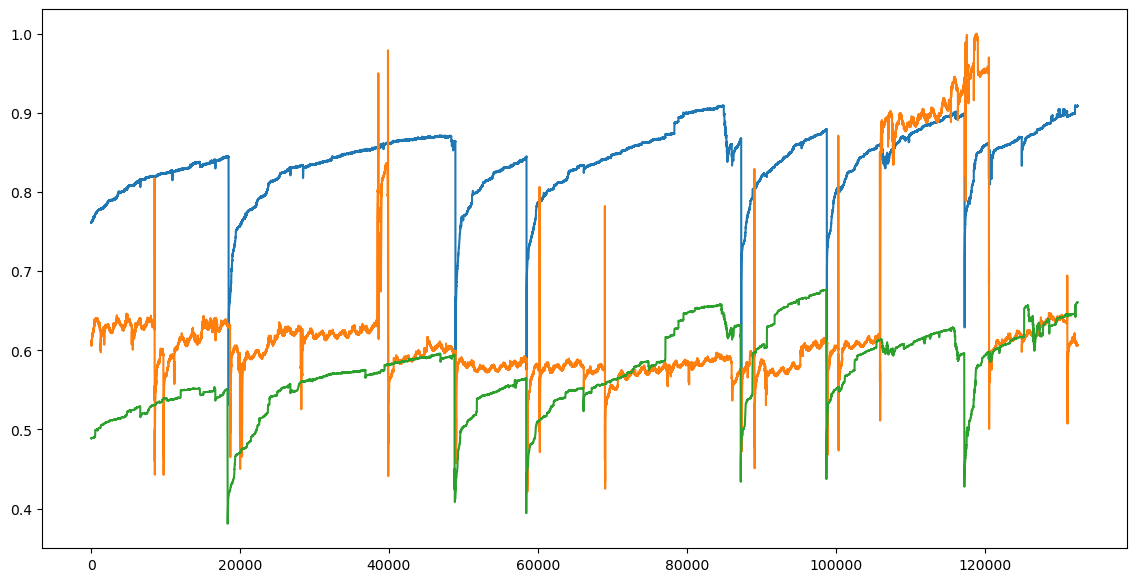

In [4]:
# 训练数据
features = df_train.columns[1:4]
plt.figure(figsize=(14, 7))
for feature in features:
    plt.plot(df_train.index, df_train[feature])
plt.show()

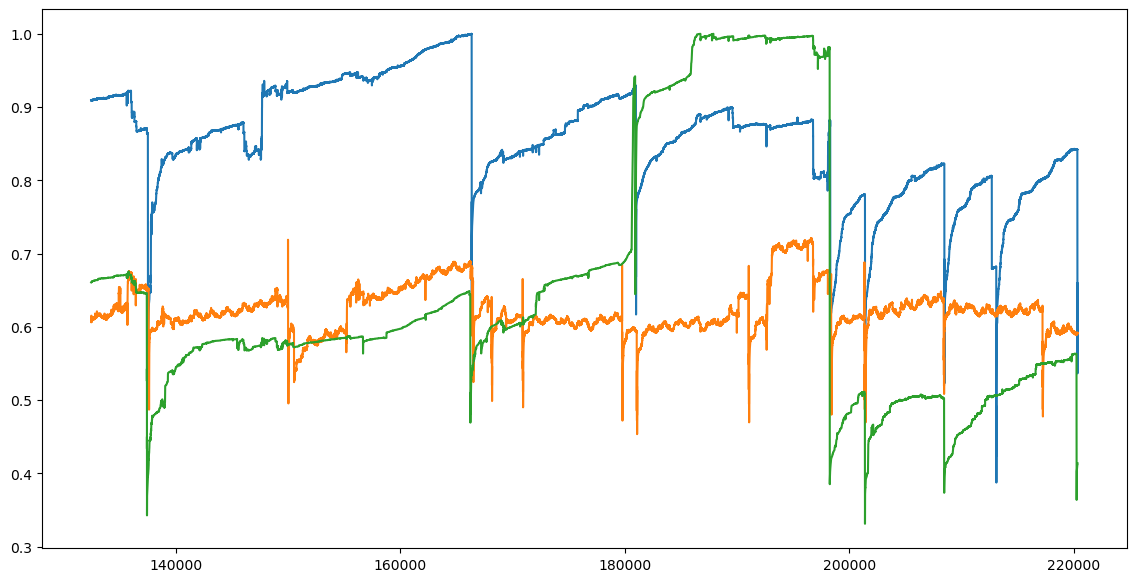

In [5]:
# 测试数据
features = df_test.columns[1:4]
plt.figure(figsize=(14, 7))
for feature in features:
    plt.plot(df_test.index, df_test[feature])
plt.show()

特征工程（参考论文 Outlier detection for multidimensional time series using deep neural networks）

In [6]:
b = 6  # Step 1 窗口长度
f = 4  # Step 2 窗口长度
sql_len = 1  # 序列长度

# train_data = enrich_raw_ts(df_train, b, f, model='cnn', norm=True)
# test_data = enrich_raw_ts(df_test, b, f, model='cnn', norm=True)

In [7]:
# train_data = np.load('dataset/2dcnn_train.npy')
train_data = np.load('dataset/2dcnn_train_norm.npy')
train_data = train_data.tolist()
# test_data = np.load('dataset/2dcnn_test.npy')
test_data = np.load('dataset/2dcnn_test_norm.npy')
test_data = test_data.tolist()

In [8]:
train_set = TSDataset(train_data, sql_len)
test_set = TSDataset(test_data, sql_len)
train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
train_single_loader = DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

# 模型训练

In [9]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))

In [10]:
cnn_ae_path = "models/ckpts/2dcnn-ae.pth"

2DCNN-AE（参考论文 Outlier detection for multidimensional time series using deep neural networks）

In [11]:
dropout_ratio = 0.2

model = CNNAE(dropout_ratio)

In [12]:
epoch = 200
learning_rate = 0.01

criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

history_loss, best_model = train_model(device, criterion, epoch, model, optimizer, scheduler, train_loader)

Epoch 1/200, Loss: 0.008260909704980335
Epoch 2/200, Loss: 0.003416244586407127
Epoch 3/200, Loss: 0.002798219928855068
Epoch 4/200, Loss: 0.002584888808412385
Epoch 5/200, Loss: 0.002424025181175222
Epoch 6/200, Loss: 0.0023286051782716185
Epoch 7/200, Loss: 0.0022532536903168685
Epoch 8/200, Loss: 0.0022299317853752844
Epoch 9/200, Loss: 0.0021910169809778554
Epoch 10/200, Loss: 0.0021491858653083645
Epoch 11/200, Loss: 0.0021149140600393193
Epoch 12/200, Loss: 0.002088571651059106
Epoch 13/200, Loss: 0.002063631159105924
Epoch 14/200, Loss: 0.0020389177586790596
Epoch 15/200, Loss: 0.0020268075536869095
Epoch 16/200, Loss: 0.0019976317869895453
Epoch 17/200, Loss: 0.0019883882144794743
Epoch 18/200, Loss: 0.001981711969078767
Epoch 19/200, Loss: 0.0019711479107423673
Epoch 20/200, Loss: 0.001966923582199034
Epoch 21/200, Loss: 0.0019477707153708753
Epoch 22/200, Loss: 0.0019406776962700675
Epoch 23/200, Loss: 0.0019363184539575922
Epoch 24/200, Loss: 0.001919589485821411
Epoch 25/20

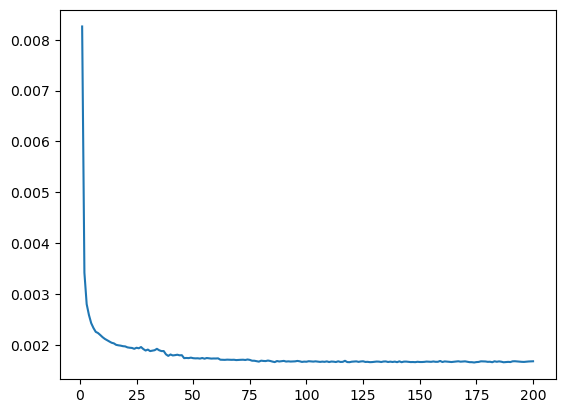

In [13]:
x = [i+1 for i in range(epoch)]
plt.plot(x, history_loss)
plt.show()

In [15]:
save_model(best_model, cnn_ae_path)

# 异常检测

In [11]:
result_path = "result/detection_1.npy"

In [12]:
dropout_ratio = 0.2

cnn_ae = CNNAE(dropout_ratio)
load_model(cnn_ae, cnn_ae_path)

In [13]:
criterion = nn.MSELoss(reduction='mean')

outliers = detect_outlier(device, criterion, cnn_ae, train_single_loader, test_loader, sql_len)

Threshold: 0.02616014927625656
Outliers: [556, 1179, 1180, 1227, 4947, 5422, 10634, 10635, 10636]


In [14]:
start_ts = 132480
end_ts = 220320

save_result(start_ts, end_ts, outliers, b, f, result_path)

Number of Outliers: 108
Outliers: [135816, 135817, 135818, 135819, 135820, 135821, 135822, 135823, 135824, 135825, 135826, 135827, 135828, 135829, 135830, 139554, 139555, 139556, 139557, 139558, 139559, 139560, 139561, 139562, 139563, 139564, 139565, 139566, 139567, 139568, 139569, 139570, 139571, 139572, 139573, 139574, 139842, 139843, 139844, 139845, 139846, 139847, 139848, 139849, 139850, 139851, 139852, 139853, 139854, 139855, 139856, 162162, 162163, 162164, 162165, 162166, 162167, 162168, 162169, 162170, 162171, 162172, 162173, 162174, 162175, 162176, 165012, 165013, 165014, 165015, 165016, 165017, 165018, 165019, 165020, 165021, 165022, 165023, 165024, 165025, 165026, 196284, 196285, 196286, 196287, 196288, 196289, 196290, 196291, 196292, 196293, 196294, 196295, 196296, 196297, 196298, 196299, 196300, 196301, 196302, 196303, 196304, 196305, 196306, 196307, 196308, 196309, 196310]
